# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
farthest_point = manager.Value("s", "test")

# Non shared resources
filename = 'hoasa-coreset'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports  # Returns list of reports, one for each output label
    }

In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def coreset_sampling(aspect_model, sentiment_model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.eval()
    sentiment_model.to(device)
    sentiment_model.eval()

    farthest_data = farthest_point.value
    if farthest_data is not None:
        X_pool.append(farthest_data)
        
    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool,
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
            embeddings = aspect_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        for i in range(len(outputs)):
            aspect_outputs[batch['ori_indices'][i].item()] = embeddings.last_hidden_state[i].mean(dim=1).cpu().numpy()
            
            for j in range(len(outputs[i])):
                if int(outputs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    if len(data) > 0:
        sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
        sentiment_loader = torch.utils.data.DataLoader(
            sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
        )
    
        # Pass through sentiment analysis model
        for batch in sentiment_loader:
            token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
    
            with torch.no_grad():
                outputs = sentiment_model.base_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    
            for i in range(len(outputs.last_hidden_state)):
                ori_index = batch['ori_indices'][i].item()
                if ori_index in sentiment_outputs.keys():
                    sentiment_outputs[ori_index].append(outputs.last_hidden_state[i].mean(dim=1).cpu().numpy())
                else:
                    sentiment_outputs[ori_index] = [outputs.last_hidden_state[i].mean(dim=1).cpu().numpy()]

    for key, val in sentiment_outputs.items():
        sentiment_outputs[key] = np.mean(val, axis=0)

    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = np.mean([val, aspect_outputs[key]], axis=0)

        embeddings = np.array(list(aspect_outputs.values()))
        distance_matrix = pairwise_distances(embeddings)
        selected_indices = distance_matrix.shape[0] - 1 if farthest_data is not None else 0

        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point.value = aspect_dataset[sorted_dist[0]]['ori_text']

        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
            
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'ac': [y_train[i][0] for i in temp],
                'air_panas': [y_train[i][1] for i in temp],
                'bau': [y_train[i][2] for i in temp],
                'general': [y_train[i][3] for i in temp],
                'kebersihan': [y_train[i][4] for i in temp],
                'linen': [y_train[i][5] for i in temp],
                'service': [y_train[i][6] for i in temp],
                'sunrise_meal': [y_train[i][7] for i in temp],
                'tv': [y_train[i][8] for i in temp],
                'wifi': [y_train[i][9] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

        end_time = time.time() 
        duration = end_time - start_time

        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
        
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            farthest_point,
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.7995, F1 Micro: 0.8876, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4747, Accuracy: 0.801, F1 Micro: 0.8892, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4337, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.425, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4065, Accuracy: 0.8064, F1 Micro: 0.8916, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4121, Accuracy: 0.8101, F1 Micro: 0.8933, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3857, Accuracy: 0.8177, F1 Micro: 0.8971, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3725, Accuracy: 0.8321, F1 Micro: 0.9044, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6014, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5503, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4934, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3898, Accuracy: 0.6878, F1 Micro: 0.6878, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3441, Accuracy: 0.7488, F1 Micro: 0.7488, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.7634, F1 Micro: 0.7634, F1 Macro: 0.719
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.7439, F1 Micro: 0.7439, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2402, Accuracy: 0.7756, F1 Micro: 0.7756, F1 Macro: 0.7399
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.7512, F1 Micro: 0.7512, F1 Macro: 0.6996
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5657, Accuracy: 0.8062, F1 Micro: 0.8911, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5232, Accuracy: 0.8142, F1 Micro: 0.8955, F1 Macro: 0.8905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5029, Accuracy: 0.8319, F1 Micro: 0.9027, F1 Macro: 0.8952
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4491, Accuracy: 0.8422, F1 Micro: 0.9091, F1 Macro: 0.903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4193, Accuracy: 0.8646, F1 Micro: 0.921, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.362, Accuracy: 0.8911, F1 Micro: 0.9353, F1 Macro: 0.9306
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3234, Accuracy: 0.8984, F1 Micro: 0.9393, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2718, Accuracy: 0.9087, F1 Micro: 0.9449, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5896, Accuracy: 0.7203, F1 Micro: 0.7203, F1 Macro: 0.434
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4363, Accuracy: 0.8165, F1 Micro: 0.8165, F1 Macro: 0.7526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3608, Accuracy: 0.8381, F1 Micro: 0.8381, F1 Macro: 0.7685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2914, Accuracy: 0.8562, F1 Micro: 0.8562, F1 Macro: 0.8026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2406, Accuracy: 0.8709, F1 Micro: 0.8709, F1 Macro: 0.8285
Epoch 6/10, Train Loss: 0.1783, Accuracy: 0.8652, F1 Micro: 0.8652, F1 Macro: 0.8087
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1747, Accuracy: 0.8743, F1 Micro: 0.8743, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.8845, F1 Micro: 0.8845, F1 Macro: 0.8479
Epoch 9/10, Train Loss: 0.1309, Accuracy: 0.8652, F1 Micro: 0.8652, F1 Macro: 0.808
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5227, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4471, Accuracy: 0.829, F1 Micro: 0.9017, F1 Macro: 0.8962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4188, Accuracy: 0.8552, F1 Micro: 0.916, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.354, Accuracy: 0.8807, F1 Micro: 0.9297, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2972, Accuracy: 0.9012, F1 Micro: 0.9411, F1 Macro: 0.9376
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2497, Accuracy: 0.9167, F1 Micro: 0.9497, F1 Macro: 0.9466
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2176, Accuracy: 0.9241, F1 Micro: 0.9541, F1 Macro: 0.9511
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1878, Accuracy: 0.9365, F1 Micro: 0.9612, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5328, Accuracy: 0.8035, F1 Micro: 0.8035, F1 Macro: 0.7257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3269, Accuracy: 0.849, F1 Micro: 0.849, F1 Macro: 0.7936
Epoch 3/10, Train Loss: 0.2422, Accuracy: 0.8418, F1 Micro: 0.8418, F1 Macro: 0.7645
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2215, Accuracy: 0.8728, F1 Micro: 0.8728, F1 Macro: 0.8274
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1867, Accuracy: 0.8862, F1 Micro: 0.8862, F1 Macro: 0.8493
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.8738, F1 Micro: 0.8738, F1 Macro: 0.8228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1312, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8598
Epoch 8/10, Train Loss: 0.1021, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8388
Epoch 9/10, Train Loss: 0.0758, Accuracy: 0.8811, F1 Micro: 0.8811, F1 Macro: 0.8347
Epoch 10/10, Train Loss: 0.0518, Accuracy: 0.8842, F1 Micro: 0.8842, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5227, Accuracy: 0.8099, F1 Micro: 0.8933, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4668, Accuracy: 0.8441, F1 Micro: 0.9094, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4017, Accuracy: 0.8847, F1 Micro: 0.9316, F1 Macro: 0.9268
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3207, Accuracy: 0.9083, F1 Micro: 0.9452, F1 Macro: 0.9428
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2603, Accuracy: 0.926, F1 Micro: 0.9552, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.217, Accuracy: 0.9351, F1 Micro: 0.9604, F1 Macro: 0.9575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1882, Accuracy: 0.9411, F1 Micro: 0.964, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1664, Accuracy: 0.9434, F1 Micro: 0.9653, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4953, Accuracy: 0.825, F1 Micro: 0.825, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3501, Accuracy: 0.8559, F1 Micro: 0.8559, F1 Macro: 0.8041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2456, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1877, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.8591
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.8917, F1 Micro: 0.8917, F1 Macro: 0.8567
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.8936, F1 Micro: 0.8936, F1 Macro: 0.8614
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8294
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.8537
Epoch 9/10, Train Loss: 0.0208, Accuracy: 0.8777, F1 Micro: 0.8777, F1 Macro: 0.8434
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4991, Accuracy: 0.8106, F1 Micro: 0.894, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4204, Accuracy: 0.8682, F1 Micro: 0.9223, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3333, Accuracy: 0.8969, F1 Micro: 0.9388, F1 Macro: 0.9363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2721, Accuracy: 0.9285, F1 Micro: 0.9565, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2146, Accuracy: 0.9377, F1 Micro: 0.9619, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1836, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1554, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1301, Accuracy: 0.949, F1 Micro: 0.9685, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4887, Accuracy: 0.8549, F1 Micro: 0.8549, F1 Macro: 0.8019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3149, Accuracy: 0.8707, F1 Micro: 0.8707, F1 Macro: 0.8299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.191, Accuracy: 0.8855, F1 Micro: 0.8855, F1 Macro: 0.848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1808, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.8973, F1 Micro: 0.8973, F1 Macro: 0.8658
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0713, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.874
Epoch 7/10, Train Loss: 0.0571, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8746
Epoch 8/10, Train Loss: 0.0397, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8618
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.871
Epoch 10/10, Train Loss: 0.0358, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5017, Accuracy: 0.8231, F1 Micro: 0.8992, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4161, Accuracy: 0.8753, F1 Micro: 0.9261, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3109, Accuracy: 0.9016, F1 Micro: 0.9412, F1 Macro: 0.9382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2486, Accuracy: 0.9342, F1 Micro: 0.9598, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2025, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.9607
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1655, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9662
Epoch 7/10, Train Loss: 0.146, Accuracy: 0.9472, F1 Micro: 0.9677, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1263, Accuracy: 0.9517, F1 Micro: 0.9702, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1091, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.8482, F1 Micro: 0.8482, F1 Macro: 0.8043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2711, Accuracy: 0.8696, F1 Micro: 0.8696, F1 Macro: 0.8309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.8752, F1 Micro: 0.8752, F1 Macro: 0.8487
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8667
Epoch 5/10, Train Loss: 0.091, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8544
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8647
Epoch 7/10, Train Loss: 0.0605, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8633
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8636
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0335, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8709
Epoch 10/10, Train Loss: 0.0198, Accuracy: 0.8948, F1 Micro: 0.8948, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4956, Accuracy: 0.821, F1 Micro: 0.8985, F1 Macro: 0.8927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3765, Accuracy: 0.8851, F1 Micro: 0.9323, F1 Macro: 0.9289
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2838, Accuracy: 0.9205, F1 Micro: 0.952, F1 Macro: 0.9499
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2231, Accuracy: 0.9342, F1 Micro: 0.96, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1822, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1554, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1327, Accuracy: 0.9561, F1 Micro: 0.9727, F1 Macro: 0.9699
Epoch 8/10, Train Loss: 0.1148, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.95

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.433, Accuracy: 0.7905, F1 Micro: 0.7905, F1 Macro: 0.7666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8787, F1 Micro: 0.8787, F1 Macro: 0.8426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1324, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8773
Epoch 5/10, Train Loss: 0.0966, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8578
Epoch 6/10, Train Loss: 0.0696, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8582
Epoch 7/10, Train Loss: 0.0479, Accuracy: 0.89, F1 Micro: 0.89, F1 Macro: 0.85
Epoch 8/10, Train Loss: 0.0404, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0414, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4919, Accuracy: 0.8347, F1 Micro: 0.9051, F1 Macro: 0.899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3737, Accuracy: 0.891, F1 Micro: 0.9355, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2697, Accuracy: 0.9302, F1 Micro: 0.9576, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2091, Accuracy: 0.9408, F1 Micro: 0.9639, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.175, Accuracy: 0.9458, F1 Micro: 0.9669, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9526, F1 Micro: 0.9707, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1248, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9711
Epoch 8/10, Train Loss: 0.107, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0933, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4035, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.8218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2812, Accuracy: 0.8795, F1 Micro: 0.8795, F1 Macro: 0.8421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.8897, F1 Micro: 0.8897, F1 Macro: 0.8563
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.8814, F1 Micro: 0.8814, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.09, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8815
Epoch 7/10, Train Loss: 0.0501, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro: 0.8702
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8763
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9008, F1 Micro: 0.9008, F1 Macro: 0.8723
Epoch 10/10, Train Loss: 0.0227, Accuracy: 0.899, F1 Micro: 0.899, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4784, Accuracy: 0.8337, F1 Micro: 0.904, F1 Macro: 0.8956
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3617, Accuracy: 0.9005, F1 Micro: 0.941, F1 Macro: 0.9389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2595, Accuracy: 0.9304, F1 Micro: 0.9578, F1 Macro: 0.9556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2057, Accuracy: 0.9405, F1 Micro: 0.9637, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9507, F1 Micro: 0.9697, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1374, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1207, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1037, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.8483, F1 Micro: 0.8483, F1 Macro: 0.7836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2536, Accuracy: 0.8915, F1 Micro: 0.8915, F1 Macro: 0.8598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1764, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8694
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8651
Epoch 5/10, Train Loss: 0.0896, Accuracy: 0.8888, F1 Micro: 0.8888, F1 Macro: 0.8485
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0711, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8771
Epoch 7/10, Train Loss: 0.0483, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8785
Epoch 9/10, Train Loss: 0.0403, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0228, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4787, Accuracy: 0.8377, F1 Micro: 0.9071, F1 Macro: 0.9032
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3479, Accuracy: 0.9069, F1 Micro: 0.9442, F1 Macro: 0.9411
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9592
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.196, Accuracy: 0.9464, F1 Micro: 0.9672, F1 Macro: 0.9648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1613, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1383, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.409, Accuracy: 0.8644, F1 Micro: 0.8644, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2594, Accuracy: 0.8812, F1 Micro: 0.8812, F1 Macro: 0.8382
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1665, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8722
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0945, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0639, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8907
Epoch 7/10, Train Loss: 0.0466, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8869
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8773
Epoch 9/10, Train Loss: 0.0365, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8815
Epoch 10/10, Train Loss: 0.0177, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4796, Accuracy: 0.8311, F1 Micro: 0.9035, F1 Macro: 0.8978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3331, Accuracy: 0.9116, F1 Micro: 0.9472, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.9413, F1 Micro: 0.9642, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1913, Accuracy: 0.9502, F1 Micro: 0.9695, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1538, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9709
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9559, F1 Micro: 0.9729, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0785, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4302, Accuracy: 0.845, F1 Micro: 0.845, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8278
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1346, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0883, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8882
Epoch 6/10, Train Loss: 0.0612, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8777
Epoch 7/10, Train Loss: 0.0484, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8908
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8871
Epoch 10/10, Train Loss: 0.0198, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4747, Accuracy: 0.8587, F1 Micro: 0.9182, F1 Macro: 0.9136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3257, Accuracy: 0.9227, F1 Micro: 0.9533, F1 Macro: 0.9506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2309, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1863, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9563, F1 Micro: 0.9731, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0924, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9002, F1 Micro: 0.9002, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1484, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8929
Epoch 4/10, Train Loss: 0.1114, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8924
Epoch 6/10, Train Loss: 0.0595, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8932
Epoch 7/10, Train Loss: 0.0476, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.8989
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4687, Accuracy: 0.8587, F1 Micro: 0.9177, F1 Macro: 0.9127
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3209, Accuracy: 0.9262, F1 Micro: 0.9554, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9415, F1 Micro: 0.9644, F1 Macro: 0.9621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0885, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3915, Accuracy: 0.8678, F1 Micro: 0.8678, F1 Macro: 0.8252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2209, Accuracy: 0.8976, F1 Micro: 0.8976, F1 Macro: 0.8646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1701, Accuracy: 0.9078, F1 Micro: 0.9078, F1 Macro: 0.8771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1195, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8846
Epoch 5/10, Train Loss: 0.0701, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0573, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0403, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8884
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8876
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4664, Accuracy: 0.8566, F1 Micro: 0.917, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3133, Accuracy: 0.9267, F1 Micro: 0.9558, F1 Macro: 0.9537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9533, F1 Micro: 0.9713, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1427, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9737
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1015, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0853, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.0727, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.975
Epoch 10/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4024, Accuracy: 0.8604, F1 Micro: 0.8604, F1 Macro: 0.8271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8678
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1209, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.094, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8892
Epoch 6/10, Train Loss: 0.0594, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0421, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.8925
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8868
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0243, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8911
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4585, Accuracy: 0.8696, F1 Micro: 0.9237, F1 Macro: 0.9193
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3084, Accuracy: 0.9314, F1 Micro: 0.9585, F1 Macro: 0.9565
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9477, F1 Micro: 0.968, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1702, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1396, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0717, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3913, Accuracy: 0.8752, F1 Micro: 0.8752, F1 Macro: 0.834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.8909, F1 Micro: 0.8909, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8851
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1219, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0878, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0681, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8893
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0453, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0366, Accuracy: 0.9187, F1 Micro: 0.9187, F1 Macro: 0.895
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9177, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8642, F1 Micro: 0.9212, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3016, Accuracy: 0.9271, F1 Micro: 0.9559, F1 Macro: 0.9535
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2138, Accuracy: 0.9431, F1 Micro: 0.9653, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.951, F1 Micro: 0.9699, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9717
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0979, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0688, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3738, Accuracy: 0.8719, F1 Micro: 0.8719, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1154, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8815
Epoch 5/10, Train Loss: 0.0714, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0513, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8858
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8866
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8853
Epoch 10/10, Train Loss: 0.022, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.867, F1 Micro: 0.9224, F1 Macro: 0.9173
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2935, Accuracy: 0.9306, F1 Micro: 0.9579, F1 Macro: 0.9554
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2065, Accuracy: 0.9431, F1 Micro: 0.9652, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9536, F1 Micro: 0.9715, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1339, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0952, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9628, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2142, Accuracy: 0.8946, F1 Micro: 0.8946, F1 Macro: 0.863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1121, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8876
Epoch 5/10, Train Loss: 0.0873, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8807
Epoch 6/10, Train Loss: 0.0639, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.886
Epoch 7/10, Train Loss: 0.0383, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8836
Epoch 8/10, Train Loss: 0.0314, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0292, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8863
Epoch 10/10, Train Loss: 0.0226, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4537, Accuracy: 0.8707, F1 Micro: 0.9244, F1 Macro: 0.9202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.959
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2086, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.955, F1 Micro: 0.9723, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1341, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9745
Epoch 9/10, Train Loss: 0.0635, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Mac

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3874, Accuracy: 0.8549, F1 Micro: 0.8549, F1 Macro: 0.7955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2042, Accuracy: 0.8965, F1 Micro: 0.8965, F1 Macro: 0.8638
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8827
Epoch 4/10, Train Loss: 0.09, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8812
Epoch 5/10, Train Loss: 0.0865, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9159, F1 Micro: 0.9159, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0437, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8927
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8899
Epoch 9/10, Train Loss: 0.0225, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8836
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8741, F1 Micro: 0.9256, F1 Macro: 0.9194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2824, Accuracy: 0.9345, F1 Micro: 0.9603, F1 Macro: 0.9581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2008, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.0895, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8778, F1 Micro: 0.8778, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1391, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8919
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0985, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0839, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8976
Epoch 6/10, Train Loss: 0.0677, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8889
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8919
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8854
Epoch 9/10, Train Loss: 0.0225, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8901
Epoch 10/10, Train Loss: 0.0309, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4493, Accuracy: 0.8741, F1 Micro: 0.9264, F1 Macro: 0.9231
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.9352, F1 Micro: 0.9604, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1973, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9566, F1 Micro: 0.9733, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1069, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0613, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3473, Accuracy: 0.8703, F1 Micro: 0.8703, F1 Macro: 0.829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1536, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0929, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0729, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8875
Epoch 6/10, Train Loss: 0.0533, Accuracy: 0.9034, F1 Micro: 0.9034, F1 Macro: 0.8724
Epoch 7/10, Train Loss: 0.0519, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0338, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.888
Epoch 9/10, Train Loss: 0.0252, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8853
Epoch 10/10, Train Loss: 0.0203, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4444, Accuracy: 0.878, F1 Micro: 0.9283, F1 Macro: 0.9245
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2734, Accuracy: 0.9358, F1 Micro: 0.9608, F1 Macro: 0.9585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1912, Accuracy: 0.9516, F1 Micro: 0.9703, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0871, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.974
Higher F1 achieved, saving mo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3529, Accuracy: 0.8691, F1 Micro: 0.8691, F1 Macro: 0.8278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1936, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1278, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0995, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8783
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0685, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0533, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8812
Epoch 7/10, Train Loss: 0.0347, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8688
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8676
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0329, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8798
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4358, Accuracy: 0.8839, F1 Micro: 0.9317, F1 Macro: 0.9287
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2597, Accuracy: 0.9349, F1 Micro: 0.9604, F1 Macro: 0.958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9497, F1 Micro: 0.9691, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1012, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9757
Epoch 8/10, Train Loss: 0.0711, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3769, Accuracy: 0.8708, F1 Micro: 0.8708, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2036, Accuracy: 0.8954, F1 Micro: 0.8954, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1482, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1103, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8845
Epoch 5/10, Train Loss: 0.0863, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8767
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8783
Epoch 7/10, Train Loss: 0.0461, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8812
Epoch 8/10, Train Loss: 0.0448, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8808
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0158, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8847
Epoch 10/10, Train Loss: 0.025, Accuracy: 0.9099, F1 Micro: 0.9099, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4333, Accuracy: 0.8859, F1 Micro: 0.9323, F1 Macro: 0.9277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2588, Accuracy: 0.9394, F1 Micro: 0.9631, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1024, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9762
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9668, F1 Micro: 0.9794, F1 Macro: 0.9774
Epoch 9/10, Train Loss: 0.0582, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3561, Accuracy: 0.8629, F1 Micro: 0.8629, F1 Macro: 0.8194
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1986, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8682
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1439, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8858
Epoch 4/10, Train Loss: 0.1066, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0738, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8921
Epoch 6/10, Train Loss: 0.0511, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0473, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8937
Epoch 8/10, Train Loss: 0.0339, Accuracy: 0.9155, F1 Micro: 0.9155, F1 Macro: 0.8915
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8951
Epoch 10/10, Train Loss: 0.0273, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION


Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4295, Accuracy: 0.8875, F1 Micro: 0.9334, F1 Macro: 0.9296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2555, Accuracy: 0.937, F1 Micro: 0.9617, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9741
Epoch 9/10, Train Loss: 0.0572, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9744
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3442, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.8089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2028, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.138, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0841, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8839
Epoch 5/10, Train Loss: 0.0768, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0532, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8847
Epoch 7/10, Train Loss: 0.0349, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8839
Epoch 8/10, Train Loss: 0.0323, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8778
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0271, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4321, Accuracy: 0.8866, F1 Micro: 0.9334, F1 Macro: 0.9303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2542, Accuracy: 0.9403, F1 Micro: 0.9635, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9557, F1 Micro: 0.9726, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1416, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1123, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9763
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3452, Accuracy: 0.8723, F1 Micro: 0.8723, F1 Macro: 0.8309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1894, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1288, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0946, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0723, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.054, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8946
Epoch 7/10, Train Loss: 0.036, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8781
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8867
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8953
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4322, Accuracy: 0.8903, F1 Micro: 0.9352, F1 Macro: 0.9325
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9372, F1 Micro: 0.9618, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9523, F1 Micro: 0.9708, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9594, F1 Micro: 0.9748, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9667, F1 Micro: 0.9793, F1 Macro: 0.9773
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3463, Accuracy: 0.8682, F1 Micro: 0.8682, F1 Macro: 0.8364
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1862, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.129, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8821
Epoch 4/10, Train Loss: 0.0937, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8814
Epoch 5/10, Train Loss: 0.0698, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8803
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0632, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8957
Epoch 7/10, Train Loss: 0.0392, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8821
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8874
Epoch 9/10, Train Loss: 0.0268, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8782
Epoch 10/10, Train Loss: 0.0359, Accuracy: 0.9182, F1 Micro: 0.9182, F1 Macro: 0.8951

Sentiment analysi

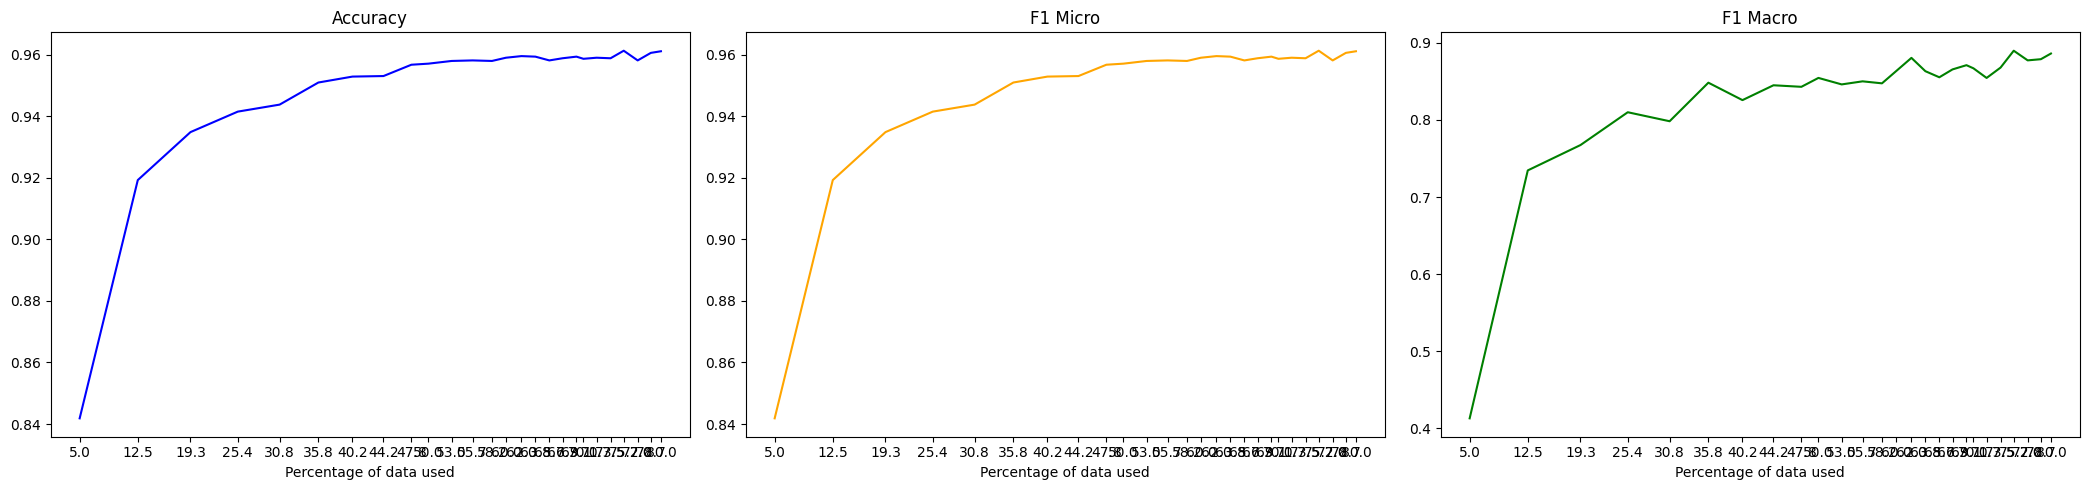

In [22]:
active_learning(seeds[0], 0)

## RUN 2

In [23]:
# active_learning(seeds[1], 1)

## RUN 3

In [24]:
# active_learning(seeds[2], 2)

## RUN 4

In [25]:
# active_learning(seeds[3], 3)

## RUN 5

In [26]:
# active_learning(seeds[4], 4)